**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [ ]:
! pip install lightning torchmetrics torchinfo

3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [1]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# Identification d'activité humaine

Dans ce notebook, vous allez travailler sur le jeu de données [Human Activity Recognition](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones).

Ce jeu de données a été construit à partir d'enregistrements de 30 sujets effectuant des activités de la vie quotidienne tout en portant un smartphone monté à la taille équipé de capteurs d'inertie.

Voici quelques informations supplémentaires sur les expériences effectuées :

> Les expériences ont été menées avec un groupe de 30 volontaires âgés de 19 à 48 ans. Chaque personne a effectué six activités (*marche*, *monter des marches*, *descendre des marches*, *assis*, *debout*, *couché*) en portant un smartphone (Samsung Galaxy S II) à la taille. En utilisant l'accéléromètre et le gyroscope intégrés, ils ont capturé l'accélération linéaire et la vitesse angulaire de trois axes à une fréquence constante de 50 Hz. Les expériences ont également été enregistrées avec une caméra afin d'étiqueter les données manuellement. L'ensemble des données obtenues a été divisé de manière aléatoire en deux ensembles, 70% des volontaires ayant été sélectionnés pour générer les données d'entraînement et 30% les données d'évaluation. Les signaux des capteurs (accéléromètre et gyroscope) ont été prétraités en appliquant des filtres anti-bruit, puis échantillonnés dans des fenêtres glissantes de largeur fixe de 2,56 secondes avec un chevauchement de 50% (128 valeurs par fenêtre).

**L'objectif est de prédire l'activité effectuée par le sujet à partir des signaux enregistrés par le capteur puis prétraités.**

## (Télé)chargement des données, visualisation et prétraitement

La fonction `load_dataset()` définie ci-dessous permet de charger (et télécharger si nécessaire) le jeu de données.

In [2]:
import torch


def load_dataset(train, path='data'):
    """Charge le jeu de données.
    
    Parameters
    ----------
    train : bool
        Si True, renvoie le jeu d'entraînement. Sinon, renvoie le
        jeu de validation.
        
    path : str
        Chemin du répertoire où charger ou télécharger le jeu de données.
    
    Returns
    -------
    X : Tensor, shape = (n_samples, 9, 128)
        Entrées.
    
    y : Tensor, shape = (n_samples,)
        Labels.
    
    subject : Tensor, shape = (n_samples,)
        Identifiants des sujets.

    """
    import numpy as np
    import os
    import zipfile

    # Download the dataset if necessary
    if not os.path.isfile(os.path.join(
        path, 'human+activity+recognition+using+smartphones.zip'
    )):
        from urllib.request import urlretrieve
    
        if not os.path.exists(path):
            os.makedirs(path)
    
        url = (
            'https://archive.ics.uci.edu/static/public/240/'
            'human+activity+recognition+using+smartphones.zip'
        )
        urlretrieve(url, os.path.join(
            path, 'human+activity+recognition+using+smartphones.zip'
        ))
    
    if not os.path.isfile(os.path.join(path, 'UCI HAR Dataset.zip')):
        with zipfile.ZipFile(
            os.path.join(path, 'human+activity+recognition+using+smartphones.zip'), 'r'
        ) as zip_ref:
            zip_ref.extractall(path)
    
    if not os.path.isdir(os.path.join(path, 'UCI HAR Dataset')):
        with zipfile.ZipFile(os.path.join(path, 'UCI HAR Dataset.zip'), 'r') as zip_ref:
            zip_ref.extractall(path)

    set_ = 'train' if train else 'test'
    file_names = [
            f'body_acc_x_{set_}.txt', f'body_acc_y_{set_}.txt', f'body_acc_z_{set_}.txt',
            f'body_gyro_x_{set_}.txt', f'body_gyro_y_{set_}.txt', f'body_gyro_z_{set_}.txt',
            f'total_acc_x_{set_}.txt', f'total_acc_y_{set_}.txt', f'total_acc_z_{set_}.txt',
        ]
    
    # Input data
    X = np.asarray([
        np.loadtxt(os.path.join(
            path, 'UCI HAR Dataset', set_, 'Inertial Signals', file
        )) for file in file_names
    ])
    X = np.transpose(X, (1, 0, 2))
    
    # Output data
    y = np.loadtxt(os.path.join(path, 'UCI HAR Dataset', set_, f'y_{set_}.txt'))
    
    # Subjects
    sujets = np.loadtxt(os.path.join(
        path, 'UCI HAR Dataset', set_, f'subject_{set_}.txt'
    ), dtype='int64')
    
    # Convert to Tensors
    X = torch.from_numpy(X).to(dtype=torch.float32)
    y = torch.from_numpy(y - 1).to(dtype=torch.int64)
    sujets = torch.from_numpy(sujets).to(dtype=torch.int64)

    return X, y, sujets

Il suffit d'appeler cette fonction pour récupérer les jeux d'entraînement et de validation.

In [3]:
X_train, y_train, sujet_train = load_dataset(train=True)
X_val, y_val, sujet_val = load_dataset(train=False)

Pour chaque jeu de données, nous avons 3 variables Python :

* `X` contient les entrées (c'est-à-dire les signaux) ; il s'agit d'un tenseur de taille `(n_observations, n_canaux, n_points)`.
* `y` contient les sorties (c'est-à-dire les labels) ; il s'agit d'un tenseur de taille `(n_observations,)`.
* `sujet` contient l'identification des sujets (car plusieurs activités ont été enregistrées pour chaque sujet) ; il s'agit d'un tenseur de taille `(n_observations,)`.

Chaque observation est constituée de :
* Entrée : 9 signaux (`n_canaux`) de longueur 128 (`n_points`).
* Sortie : 1 label

### Exercice 1

Déterminez le nombre d'enregistrements dans les jeux d'entraînement et de validation.
Déterminez (par du code) la taille de chaque observation (on admettra que toutes les observations ont la même taille, il suffit donc de calculer la taille d'une seule observation).

In [4]:
print(f"Nombre d'enregistrements dans le jeu d'entraînement = {len(y_train)}")
print(f"Nombre d'enregistrements dans le jeu de validation = {len(y_val)}")
print(f"Taille d'une observation = {tuple(X_train[0].shape)}")

Nombre d'enregistrements dans le jeu d'entraînement = 7352
Nombre d'enregistrements dans le jeu de validation = 2947
Taille d'une observation = (9, 128)


La fonction `plot_sample()` définie ci-dessous permet d'afficher une observation.

In [5]:
import matplotlib.pyplot as plt


def plot_sample(X, y, idx):
    """Plot the sample for the given index.

    Parameters
    ----------
    X : array, shape = (n_samples, 9, 128)
        Input samples.
    
    y : array, shape = (n_samples)
        Target samples.
    
    idx : int
        Index of the sample to plot.
    """
    if not 0 <= idx < len(X):
        raise ValueError("The index is not valid.")
        
    label_mapping = {
        0: 'Walking',
        1: 'Walking upstairs',
        2: 'Walking downstairs',
        3: 'Sitting',
        4: 'Standing',
        5: 'Laying'
    }
        
    labels = [
        'Body acceleration - X',
        'Body acceleration - Y',
        'Body acceleration - Z',
        'Body gyroscope - X',
        'Body gyroscope - Y',
        'Body gyroscope - Z',
        'Total acceleration - X',
        'Total acceleration - Y',
        'Total acceleration - Z'
    ]
    
    for i, label in enumerate(labels):
        plt.plot(X[idx, i], label=label)
    plt.legend(bbox_to_anchor=(1., 1.))
    _ = plt.title(label_mapping[y[idx].item()])

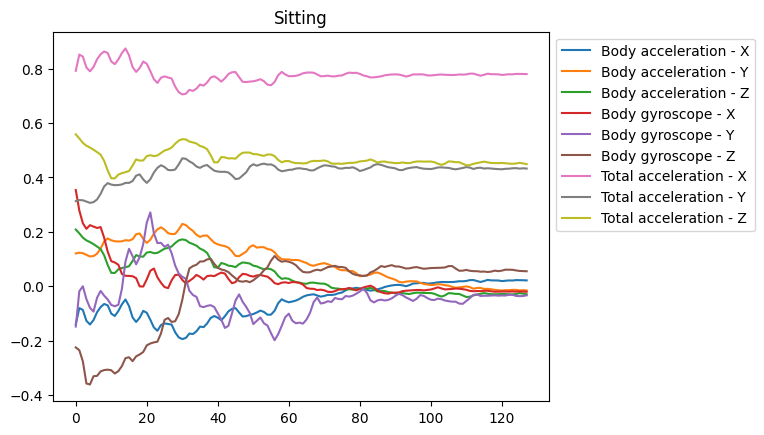

In [6]:
plot_sample(X_train, y_train, 32)

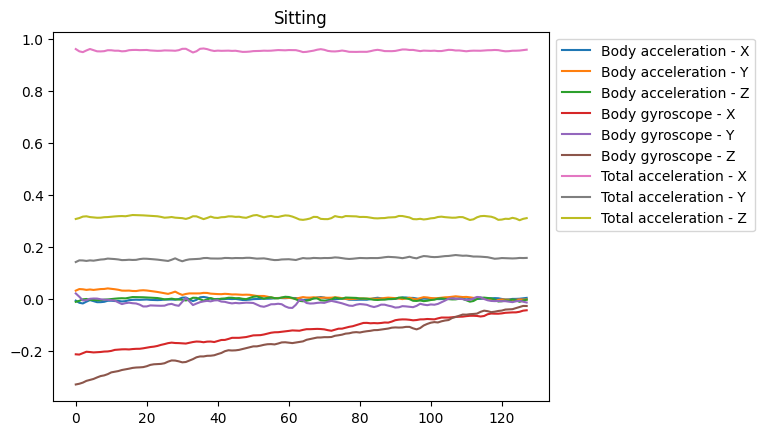

In [7]:
plot_sample(X_train, y_train, 39)

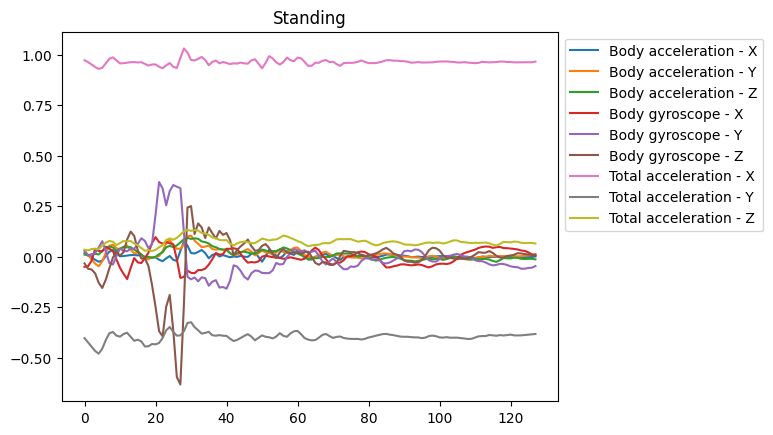

In [8]:
plot_sample(X_val, y_val, 23)

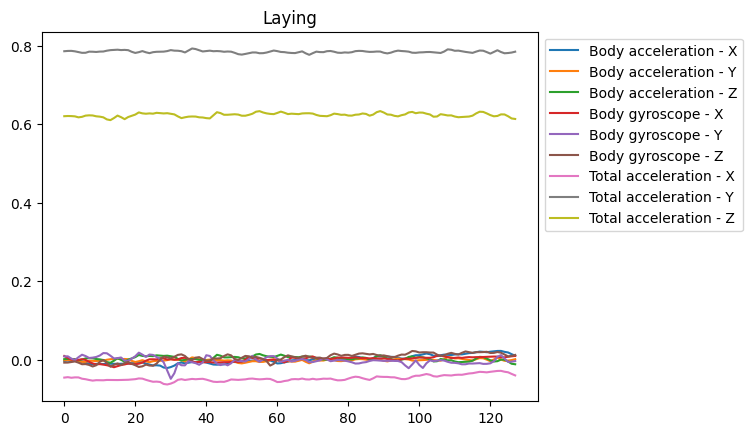

In [9]:
plot_sample(X_val, y_val, 76)

### Exercice 3

L'objectif de l'inférence est d'être capable d'identifier les activités de nouveaux sujets (c'est-à-dire de sujets qui ne sont pas présents dans le jeu d'entraînement).
Vérifiez que l'intersection entre l'ensemble des sujets du jeu d'entraînement et celui des sujets du jeu de validation est vide.
Pour ce faire, vous pouvez utiliser dans cet ordre :

* la fonction [torch.unique()](https://pytorch.org/docs/stable/generated/torch.unique.html) qui renvoie les éléments uniques d'un tenseur,
* la méthode [torch.Tensor.tolist()](https://pytorch.org/docs/stable/generated/torch.Tensor.tolist.html) qui transforme un tenseur en une liste,
* la fonction native [set()](https://docs.python.org/fr/3/library/functions.html#func-set) pour créer un ensemble à partir d'une liste,
* l'opérateur `&` qui effectue l'intersection entre deux ensembles.

In [10]:
set(sujet_train.unique().tolist()) & set(sujet_val.unique().tolist()) == set()

True

### Exercice 4

Calculez la distribution des classes sur les jeux d'entraînement et de validation.
Vous pouvez utiliser la fonction [torch.bincount()](https://pytorch.org/docs/stable/generated/torch.bincount.html).
Utilisez ces résultats pour proposer une métrique de classification pertinente.

In [11]:
print(
    f"Distribution des classes sur le jeu d'entraînement = "
    f"{torch.bincount(y_train) / len(y_train) * 100}"
)
print(
    f"Distribution des classes sur le jeu de validation = "
    f"{torch.bincount(y_val) / len(y_val) * 100}"
)

Distribution des classes sur le jeu d'entraînement = tensor([16.6757, 14.5947, 13.4113, 17.4918, 18.6888, 19.1376])
Distribution des classes sur le jeu de validation = tensor([16.8307, 15.9824, 14.2518, 16.6610, 18.0523, 18.2219])


**Réponse** : Les classes ne sont pas parfaitement équilibrées, mais elles sont tout de même bien équilibrées. La précision (*accuracy*) est une métrique tout à fait acceptable dans cette situation. La précision équilibrée (*balanced accuracy*) est également pertinente.

### Exercice 5

Créez votre propre classe `CustomDataset()` héritant de la classe [torch.utils.data.Dataset()](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) pour définir votre jeu de données.
Utilisez-là pour créer pour des *dataloaders* ([torch.utils.data.DataLoader()](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)) pour les jeux d'entraînement et de validation avec des lots de taille (`batch_size`) $32$.
N'oubliez pas de mélanger (`suffle`) les observations pour le jeu d'entraînement, mais pas pour le jeu de validation.

Vous pouvez vous inspirer du code utilisé pour le TP 1.2.

In [12]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataloader_train = DataLoader(
    CustomDataset(X_train, y_train), batch_size=32, shuffle=True
)
dataloader_val = DataLoader(
    CustomDataset(X_val, y_val), batch_size=32, shuffle=False
)

## Classe de base pour la classification

Vous allez entraîner plusieurs modèles avec des architectures différentes.
Néanmoins, plusieurs opérations seront identiques pour tous ces modèles.
C'est pourquoi nous allons tout d'abord définir une classe de base avec toutes les opérations identiques.
La classe `BaseClass()` définie ci-dessous va contenir ces opérations communes.

### Exercice 6

Complétez le code manquant dans les méthodes `__init__()`, `step()` et `configure_optimizers()` de la classe `BaseClass()` avec les informations suivantes :
* `__init__()` : il faut définir la fonction de perte (`self.loss`) et les métriques pour les jeux d'entraînement (`self.metric_train`) et d'évaluation (`self.metric_val`);
* `step()` : étant donné un lot d'observations (`batch`), il faut :
    + récupérer les entrées (`X`) et les labels (`y`),
    + calculer les logits pour ces entrées (`logits`),
    + calculer la fonction de coût entre les logits et les labels (`loss`),
    + calculer la classe prédite pour chacune des observations du lot (`y_pred`).
* `configure_optimizers()` : on utilisera l'algorithme d'optimisation [torch.optim.Adam()](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) avec les valeurs par défaut pour ses hyperparamètres.

In [13]:
import lightning as L
from torchmetrics import Accuracy  # To be removed


class BaseClass(L.LightningModule):
    
    def __init__(self):
        """Constructeur.
        
        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère

        ### BEGIN TODO ###
        # Initialisation de la fonction de perte
        self.loss = torch.nn.CrossEntropyLoss()
        
        # Initialisation des métriques
        self.metric_train = Accuracy(task="multiclass", num_classes=6)
        self.metric_val = Accuracy(task="multiclass", num_classes=6)
        #### END TODO ####
    
    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.
            
        dataset : {"training", "validation"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        ### BEGIN TODO ###
        X, y = batch  # X correspond aux images, y aux classes
        logits = self(X)  # Passe avant, qui renvoie les logits
        loss = self.loss(logits, y)  # Évaluation de la fonction de perte
        y_pred = logits.argmax(1)  # Prédictions du modèle
        #### END TODO ###
        
        if dataset == "training":
            metric = self.metric_train
            name = "train"
            bar_step = True
        else:
            metric = self.metric_val
            name = "val"
            bar_step = False
    
        metric_score = metric(y_pred, y) # Évaluation de la métrique
        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"metric_{name}", metric_score, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss
    
    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")
    
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")
        
    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            ------------------------------------------------
            |     Jeu      | Fonction de perte | Précision |
            | ------------ | ----------------- | --------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['metric_train'].item():^11.3%}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['metric_val'].item():^11.3%}|
            ------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.split('\n')])
        print(string)
        
    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        ### BEGIN TODO ###
        optimizer = torch.optim.Adam(self.parameters())
        #### END TODO ####
        return optimizer

## Classification par perceptron multicouche

Comme la longueur de chacun des signaux est fixe ($128$) après prétraitement des données, il est possible d'utiliser un perceptron multicouche.

Vous allez implémenter un perceptron multicouche dans la classe `MLP()` définie ci-dessous avec l'architecture séquentielle suivante :

* Aplatissement de l'observation pour la transformer en un tenseur à une dimension (un vecteur)
* Couche linéaire avec 256 variables en sortie
* Fonction d'action ReLU
* Couche de désaction (*dropout*) avec une probabilité de $0.2$
* Couche linéaire avec 64 variables en sortie
* Fonction d'action ReLU
* Couche linéaire avec 6 variables en sortie

Voici les liens vers les documentations des classes pertinentes :
[torch.nn.Flatten()](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html),
[torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html),
[torch.nn.ReLU()](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) et
[torch.nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

### Exercice 7

Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `MLP()`.
Affichez un résumé de l'architecture. Combien de paramètres entraînables a-t-elle ?

In [14]:
class MLP(BaseClass):

    def __init__(self):
        super().__init__()

        ### BEGIN TODO ###
        self.sequential = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(9 * 128, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 6),
        )
        #### END TODO ####

    def forward(self, x):
        ### BEGIN TODO ###
        logits = self.sequential(x)
        #### END TODO ####
        return logits

In [15]:
from torchinfo import summary


summary(MLP(), input_size=(32, 9, 128))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 6]                   --
├─Sequential: 1-1                        [32, 6]                   --
│    └─Flatten: 2-1                      [32, 1152]                --
│    └─Linear: 2-2                       [32, 256]                 295,168
│    └─ReLU: 2-3                         [32, 256]                 --
│    └─Dropout: 2-4                      [32, 256]                 --
│    └─Linear: 2-5                       [32, 64]                  16,448
│    └─ReLU: 2-6                         [32, 64]                  --
│    └─Linear: 2-7                       [32, 6]                   390
Total params: 312,006
Trainable params: 312,006
Non-trainable params: 0
Total mult-adds (M): 9.98
Input size (MB): 0.15
Forward/backward pass size (MB): 0.08
Params size (MB): 1.25
Estimated Total Size (MB): 1.48

**Réponse** : Le modèle a $312\ 006$ paramètres entraînables.

### Exercice 8

Entraînez votre modèle pendant $10$ époques.

In [16]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model_mlp = MLP()

trainer_mlp = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,
    logger=CSVLogger('.'),
    num_sanity_val_steps=0,
    callbacks=[TQDMProgressBar(refresh_rate=100)]
)

trainer_mlp.fit(
    model=model_mlp,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 0



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.63246      |  75.748%  |
|  Validation  |      0.51019      |  83.610%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.23188      |  91.240%  |
|  Validation  |      0.48115      |  87.716%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.17027      |  93.349%  |
|  Validation  |      0.51484      |  87.920%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.13902      |  94.423%  |
|  Validation  |      0.51495      |  88.565%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.13093      |  94.423%  |
|  Validation  |      0.63210      |  88.531%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.12108      |  94.940%  |
|  Validation  |      0.50077      |  87.818%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.11619      |  95.294%  |
|  Validation  |      0.42586      |  89.888%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.11071      |  95.199%  |
|  Validation  |      0.51776      |  88.599%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.10773      |  95.457%  |
|  Validation  |      0.68806      |  86.054%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.09967      |  95.634%  |
|  Validation  |      0.70603      |  88.531%  |
------------------------------------------------



## Classification par réseau de neurones convolutif

Comme la longueur de chacun des signaux est fixe ($128$) après prétraitement des données et que les données sont séquentielles, il est également possible et pertinent d'utiliser un réseau de neurones convolutif.

Vous allez implémenter un réseau de neurones convolutif dans la classe `CNN()` définie ci-dessous avec l'architecture séquentielle suivante :

* Couche de convolution unidimensionnelle avec $32$ canaux en sortie et un noyau de taille $9$
* Fonction d'action ReLU
* Couche de regroupement unidimensionnelle avec un noyau et un pas de taille $2$
* Couche de convolution unidimensionnelle avec $64$ canaux en sortie et un noyau de taille $9$
* Fonction d'action ReLU
* Couche de regroupement unidimensionnelle avec un noyau et un pas de taille $2$
* Aplatissement de l'entrée (en deux dimensions) pour la transformer en un tenseur à une dimension (un vecteur)
* Couche linéaire avec $1664$ variables en entrée et $256$ variables en sortie
* Fonction d'action ReLU
* Couche linéaire avec $6$ variables en sortie

Voici les liens vers les documentations des classes pertinentes :
[torch.nn.Conv1d()](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html),
[torch.nn.ReLU()](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html),
[torch.nn.MaxPool1d()](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html),
[torch.nn.Flatten()](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) et
[torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

### Exercice 9

Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `CNN()`.
Affichez un résumé de l'architecture. Combien de paramètres entraînables a-t-elle ?

In [17]:
class CNN(BaseClass):

    def __init__(self):
        super().__init__()

        ### BEGIN TODO ###
        self.sequential = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=9, out_channels=32, kernel_size=9),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
            
            torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=9),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
            
            torch.nn.Flatten(),
            torch.nn.Linear(1664, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 6),
        )
        #### END TODO ####

    def forward(self, x):
        ### BEGIN TODO ###
        logits = self.sequential(x)
        #### END TODO ####
        return logits

In [18]:
summary(CNN(), input_size=(32, 9, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 6]                   --
├─Sequential: 1-1                        [32, 6]                   --
│    └─Conv1d: 2-1                       [32, 32, 120]             2,624
│    └─ReLU: 2-2                         [32, 32, 120]             --
│    └─MaxPool1d: 2-3                    [32, 32, 60]              --
│    └─Conv1d: 2-4                       [32, 64, 52]              18,496
│    └─ReLU: 2-5                         [32, 64, 52]              --
│    └─MaxPool1d: 2-6                    [32, 64, 26]              --
│    └─Flatten: 2-7                      [32, 1664]                --
│    └─Linear: 2-8                       [32, 256]                 426,240
│    └─ReLU: 2-9                         [32, 256]                 --
│    └─Linear: 2-10                      [32, 6]                   1,542
Total params: 448,902
Trainable params: 448,902
Non-trainable params: 

**Réponse** : Le modèle a $448\ 902$ paramètres entraînables

### Exercice 10

Entraînez votre modèle pendant $10$ époques.

In [19]:
model_cnn = CNN()

trainer_cnn = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,
    logger=CSVLogger('.'),
    num_sanity_val_steps=0,
    callbacks=[TQDMProgressBar(refresh_rate=100)]
)

trainer_cnn.fit(
    model=model_cnn,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 1



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.39554      |  84.113%  |
|  Validation  |      0.35265      |  88.768%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.14011      |  94.287%  |
|  Validation  |      0.30288      |  90.770%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.11645      |  95.171%  |
|  Validation  |      0.25268      |  90.567%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.11405      |  94.940%  |
|  Validation  |      0.25510      |  91.008%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.11138      |  95.239%  |
|  Validation  |      0.25222      |  91.653%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.10606      |  95.443%  |
|  Validation  |      0.22851      |  91.449%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.09781      |  95.566%  |
|  Validation  |      0.28204      |  91.619%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.11110      |  95.280%  |
|  Validation  |      0.27077      |  90.329%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.10608      |  95.539%  |
|  Validation  |      0.22044      |  92.535%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.08540      |  95.906%  |
|  Validation  |      0.32264      |  91.347%  |
------------------------------------------------



## Classification par réseau de neurones récurrent

Comme les données sont séquentielles, il est également possible et pertinent d'utiliser un réseau de neurones récurrent.

Vous allez implémenter un réseau de neurones récurrent dans la classe `RNN()` définie ci-dessous avec l'architecture séquentielle suivante :

* Couche récurrente de type LSTM **bidirectionnelle** avec $256$ variables pour chaque état caché
* Couche linéaire avec 6 variables en sortie

Voici les liens vers les documentations des classes pertinentes :
[torch.nn.LSTM()](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) et
[torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

### Exercice 11

Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `RNN()`.
Affichez un résumé de l'architecture. Combien de paramètres entraînables a-t-elle ?

In [20]:
class RNN(BaseClass):

    def __init__(self):
        super().__init__()

        ### BEGIN TODO ###
        self.lstm = torch.nn.LSTM(9, 256, bidirectional=True, batch_first=True)
        self.linear = torch.nn.Linear(512, 6)
        #### END TODO ####

    def forward(self, x):
        ### BEGIN TODO ###
        x = torch.transpose(x, 1, 2)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.nn.Flatten()(torch.transpose(h_n, 0, 1))
        logits = self.linear(h_n)
        #### END TODO ####
        return logits

In [21]:
summary(RNN(), input_size=(32, 9, 128))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [32, 6]                   --
├─LSTM: 1-1                              [32, 128, 512]            546,816
├─Linear: 1-2                            [32, 6]                   3,078
Total params: 549,894
Trainable params: 549,894
Non-trainable params: 0
Total mult-adds (G): 2.24
Input size (MB): 0.15
Forward/backward pass size (MB): 16.78
Params size (MB): 2.20
Estimated Total Size (MB): 19.13

**Réponse** : Le modèle a $549\ 894$ paramètres entraînables.

### Exercice 12

Entraînez votre modèle pendant $10$ époques.

In [22]:
model_rnn = RNN()

trainer_rnn = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,
    logger=CSVLogger('.'),
    num_sanity_val_steps=0,
    callbacks=[TQDMProgressBar(refresh_rate=100)]
)

trainer_rnn.fit(
    model=model_rnn,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 2



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      1.25109      |  45.022%  |
|  Validation  |      1.28193      |  49.712%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      1.19495      |  52.176%  |
|  Validation  |      1.12943      |  50.696%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      1.14425      |  53.251%  |
|  Validation  |      1.22484      |  50.322%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.99506      |  60.215%  |
|  Validation  |      0.99240      |  62.029%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.85440      |  65.792%  |
|  Validation  |      1.36982      |  42.280%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      1.14366      |  55.509%  |
|  Validation  |      0.95882      |  59.043%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.86107      |  64.840%  |
|  Validation  |      1.23050      |  44.147%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.87466      |  61.820%  |
|  Validation  |      0.81857      |  63.828%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.63780      |  72.552%  |
|  Validation  |      0.68473      |  71.666%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.60326      |  76.931%  |
|  Validation  |      0.73381      |  72.650%  |
------------------------------------------------



### Exercice 13

Finalement, lequel de vos trois modèles est le meilleur ? Justifiez votre réponse.

> **Remarque** : Nous n'avons pas fixé la [graine aléatoire](https://fr.wikipedia.org/wiki/Graine_aléatoire) pour des générateurs de nombres pseudo-aléatoires. Les nombres donnés dans cet response correspondent aux résultats obtenus et affichés dans la version originale de ce notebook. Si vous l'exécutez à nouveau, vous aurez des résultats différents.

**Réponse** : Nous avons obtenu les résultats suivants sur le jeu de validation :


| Modèle | Accuracy (dernière époque) | Accuracy (meilleur époque) |
|--------|----------------------------|----------------------------|
| MLP | 88.531% | 89.888% |
| CNN | 91.347% | 92.535% |
| RNN | 72.650% | 72.650% |

Les meilleurs résultats ont été obtenus par le réseau de neurones convolutifs.